# Summary of Findings

### Introduction
This dataset includes more than 12,000 civilian complaints filed against NYPD police officers from 1985 to early 2020, available to NYC's Civilian Complaint Review Board (CCRB). Complaints included are only those of officers still on the force as of late June 2020, as well as those which were confirmed to have actually happened. Regardless, not all complaints were ruled to have violated the NYPD's rules of conduct.

The data also includes demographic information about the complainants and the officers in each case, as well as the type and outcome of the complaints.

We intend to use the demographic information provided in conjunction with the outcomes of each case in order to investigate if gender played a role in the validation of a complainant’s case. 

### Cleaning and EDA
We decided to keep only a few columns of our dataset for the sake of simplicity in the EDA (as well as the fact that they would not be needed for our hypothesis testing). We kept the columns 'mos_gender', 'complainant_gender' and 'board_disposition'. We also simplified the 'board_disposition' column to have only 3 possible values: 'substantiated', 'unsubstatiated', and 'exonerated'. We did this because the 'substantiated' values were split up into different categories, mixing up the data granularity in the column and impairing visualizations.

We then performed univariate analyses of each variable, bivariate analyses of each pair of variables, and a multivariate analysis of all three columns together.

We found that female complainants were reported to be less likely to have their complaints ruled as substantiated, as well as other smaller findings.

### Assessment of Missingness
To assess the missingness of our data, we attempt to find out the underlying mechanisms behind the missingness of our data. Our clean dataset has many missing values for the gender of the complainant of each case, therefore we decided to investigate this.

We first made a numerical analysis comparing the values of the columns in our dataframe when the gender of the complainant is missing or not missing. Then, we ran permutation tests to investigate if the missingness of the complainant gender could be related to the gender of the officer or the category of the complaint.

We found that the differences in proportions of officer genders and categories of the complaints given that the gender of the complaintant was missing were both unlikely to have been due to random chance. The p-values found were both 0 in 1000 random permutations.

Due to the quite extreme results of this initial assessment of missingness, we decided to continue our assessment of missingness for other variables in our dataset using more permutation tests. We again found some statistically significant results, indicating that the missingness of the complainant gender could be related to the ethnicity of the officer, the ethnicity of the complainant and the specific allegation of the complaint with p-values of 0.013, 0 and 0, respectfully.

Overall, we found that there is good chance to believe that the fact that a complainant's gender is missing depends on the gender and ethnicity of the officer, the ethnicity of the complainant, and the category and specific allegation of the complaint.

### Hypothesis Test
We sought to assess if gender played a role in the validation of a complainant’s case. Our null hypothesis is that the rate at which cases go against the complainer is equal for male officer vs male complainant cases and for male officer vs woman complainant cases. This might suggest that there is gender biased in the report.

For this, we first must define the term 'substantiated'. In this dataset, if a case was substantiated, this meant that:

> The alleged conduct occurred and it violated the rules (of the NYPD).

We decided to run our hypothesis test under the following hypotheses:

**Null**: Proportion of substantiated cases is **equal** for male-offcer vs male-complainant cases and male-officer vs female-complainant cases

**Alternative**: Proportion of substantiated cases is **not equal** for male-offcer vs male-complainant cases and male-officer vs female-complainant cases

We decided to use the difference in the difference in the proportions of substantiated (acc) for male and female complainants as our test statistic

We picked a statistical significance level of **0.05**

# Code

In [194]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures

# set plotting size parameter
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams.update({'font.size': 15})

### Cleaning and EDA

Let's first look at the top 3 rows of the dataset:

In [9]:
df_full = pd.read_csv('./NYPD-Data/allegations_202007271729.csv')
df_full.head(3)

,unique_mos_id,first_name,last_name,command_now,shield_no,complaint_id,month_received,year_received,month_closed,year_closed,...,mos_age_incident,complainant_ethnicity,complainant_gender,complainant_age_incident,fado_type,allegation,precinct,contact_reason,outcome_description,board_disposition
0,10004,Jonathan,Ruiz,078 PCT,8409,42835,7,2019,5,2020,...,32,Black,Female,38.0,Abuse of Authority,Failure to provide RTKA card,78.0,Report-domestic dispute,No arrest made or summons issued,Substantiated (Command Lvl Instructions)
1,10007,John,Sears,078 PCT,5952,24601,11,2011,8,2012,...,24,Black,Male,26.0,Discourtesy,Action,67.0,Moving violation,Moving violation summons issued,Substantiated (Charges)
2,10007,John,Sears,078 PCT,5952,24601,11,2011,8,2012,...,24,Black,Male,26.0,Offensive Language,Race,67.0,Moving violation,Moving violation summons issued,Substantiated (Charges)


Let's keep only the columns that will be useful for our investigation. These are the officer's gender, the complainant's gender, the top-level and specific categories of the complaint, the precinct associated with the complaint, the reason and outcome of contact of officer with complainant and the final finding of the CCRB.

In [13]:
columns_to_keep = ['mos_gender', 'complainant_gender', 'board_disposition']

df = df_full[columns_to_keep]

Looking at unique values in each column to find possible null values, we can see that there are nan values in the complainant gender category. These are already filled as NaNs, therefore we do not have to change them.

In [14]:
for c in df.columns:
    print(f'Unique values in {c}: {df[c].unique()}')

Unique values in mos_gender: ['M' 'F']
Unique values in complainant_gender: ['Female' 'Male' nan 'Transman (FTM)' 'Not described' 'Transwoman (MTF)'
 'Gender non-conforming']
Unique values in board_disposition: ['Substantiated (Command Lvl Instructions)' 'Substantiated (Charges)'
 'Substantiated (Command Discipline A)'
 'Substantiated (Formalized Training)' 'Unsubstantiated' 'Exonerated'
 'Substantiated (Command Discipline B)' 'Substantiated (Instructions)'
 'Substantiated (Command Discipline)' 'Substantiated (No Recommendations)'
 'Substantiated (MOS Unidentified)']


#### Univariate Analysis

Proportions of male vs female officers:

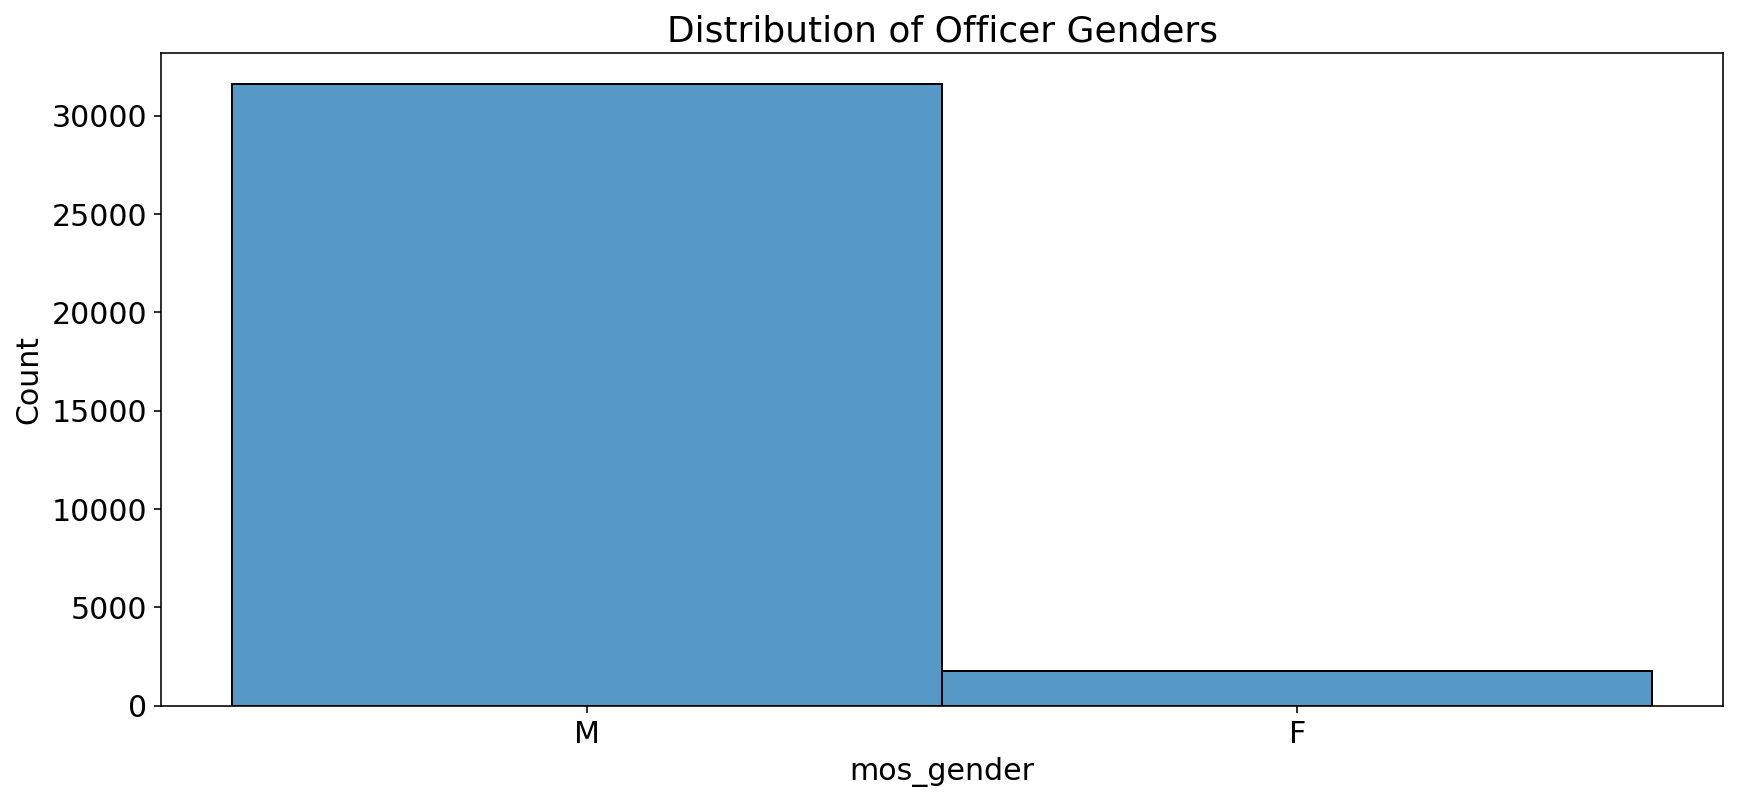

In [195]:
sns.histplot(df['mos_gender'])
plt.title('Distribution of Officer Genders')
plt.show()

In [99]:
print('Proportion values:')
df['mos_gender'].value_counts(normalize = True)

Proportion values:


M    0.947239
F    0.052761
Name: mos_gender, dtype: float64

Gender proportions of complainants:

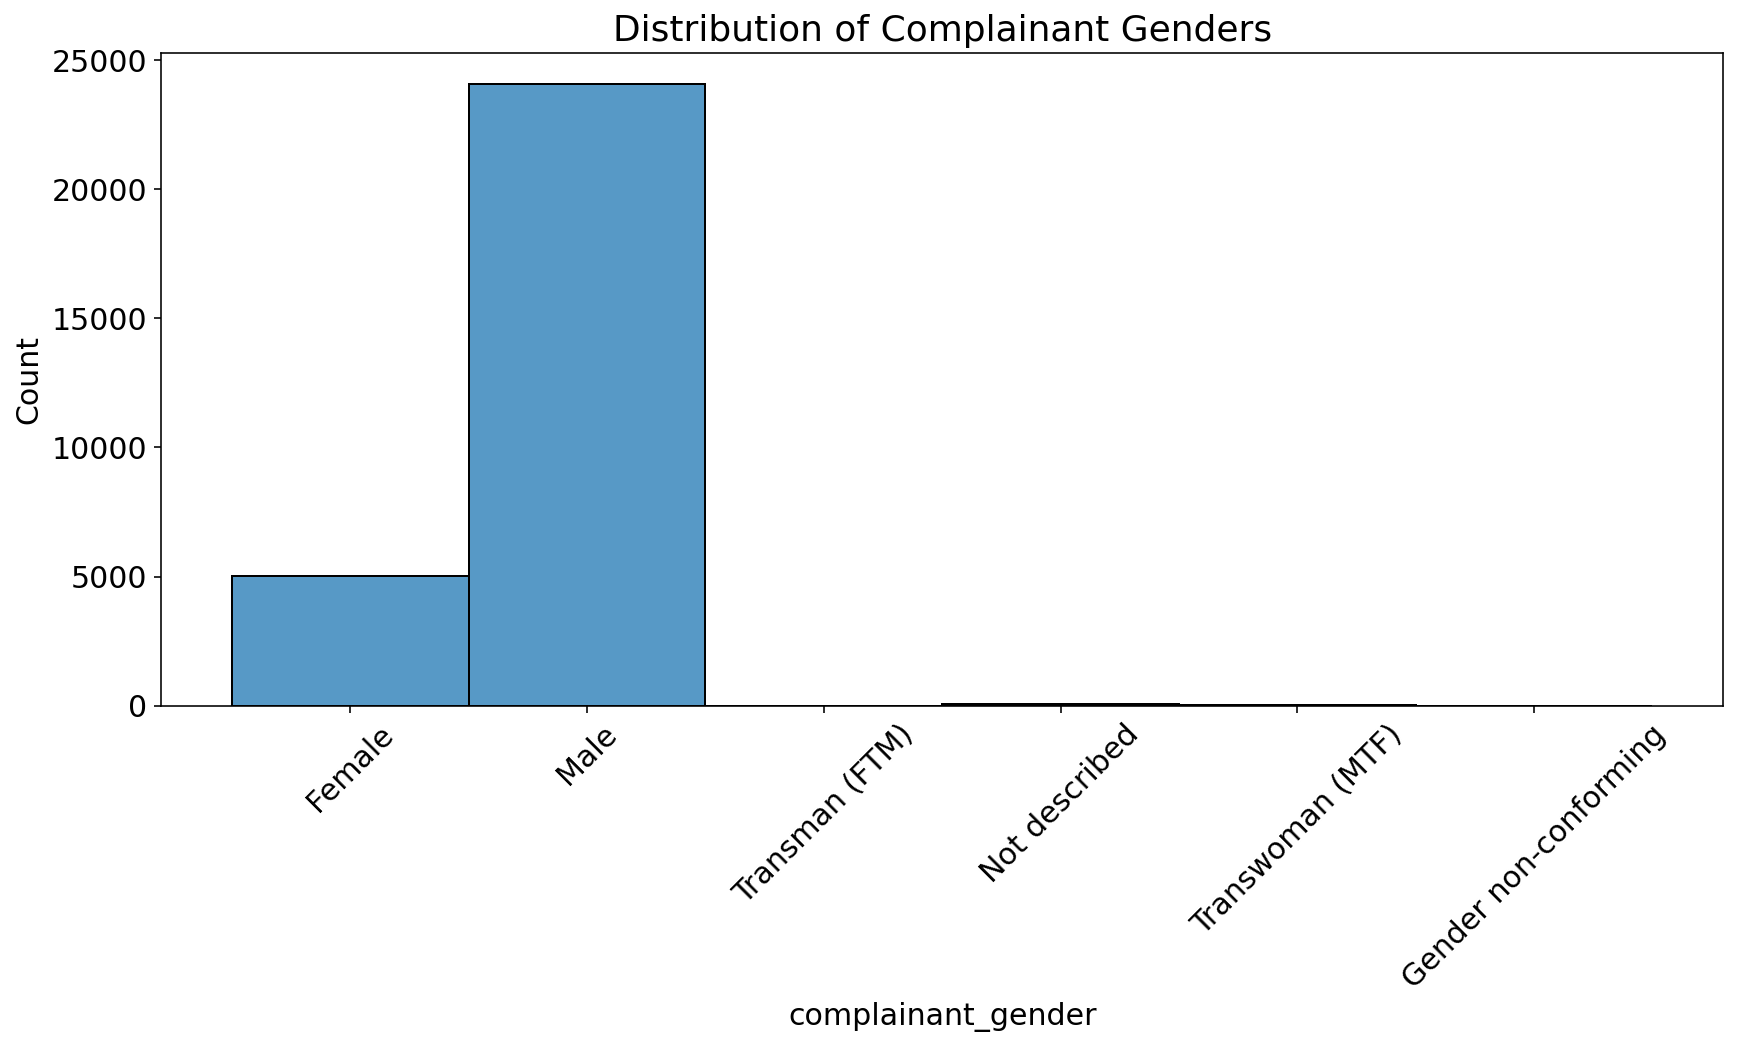

In [196]:
sns.histplot(df['complainant_gender'].dropna())
plt.title('Distribution of Complainant Genders')
plt.xticks(rotation = 45)
plt.show()

In [98]:
print('Proportion values:')
df['complainant_gender'].value_counts(normalize = True)

Proportion values:


Male                     0.824949
Female                   0.172170
Not described            0.001955
Transwoman (MTF)         0.000686
Transman (FTM)           0.000171
Gender non-conforming    0.000069
Name: complainant_gender, dtype: float64

Gender proportions amongst gender minorities:

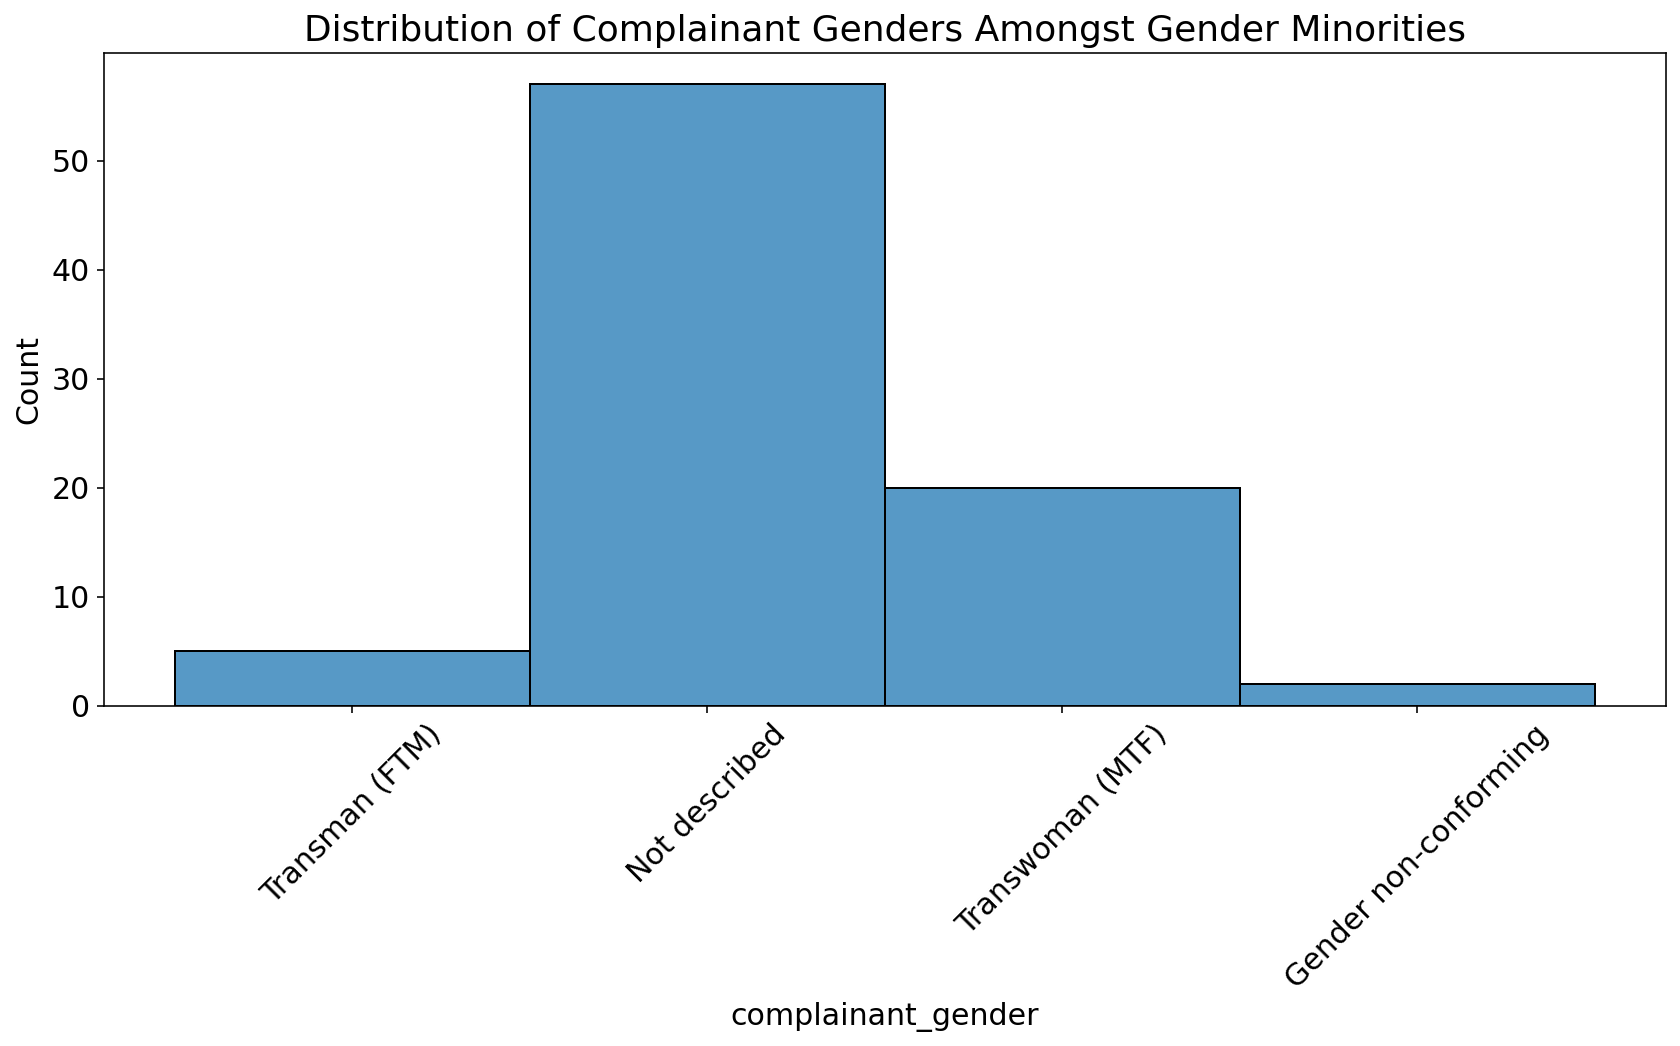

In [197]:
gender_minorities = ['Transman (FTM)', 'Not described', 'Transwoman (MTF)', 'Gender non-conforming']
are_gender_minorities = df['complainant_gender'].apply(lambda s: s in gender_minorities)

sns.histplot(df.loc[are_gender_minorities]['complainant_gender'].dropna())

plt.title('Distribution of Complainant Genders Amongst Gender Minorities')
plt.xticks(rotation = 45)
plt.show()

Distributions of board ruling:

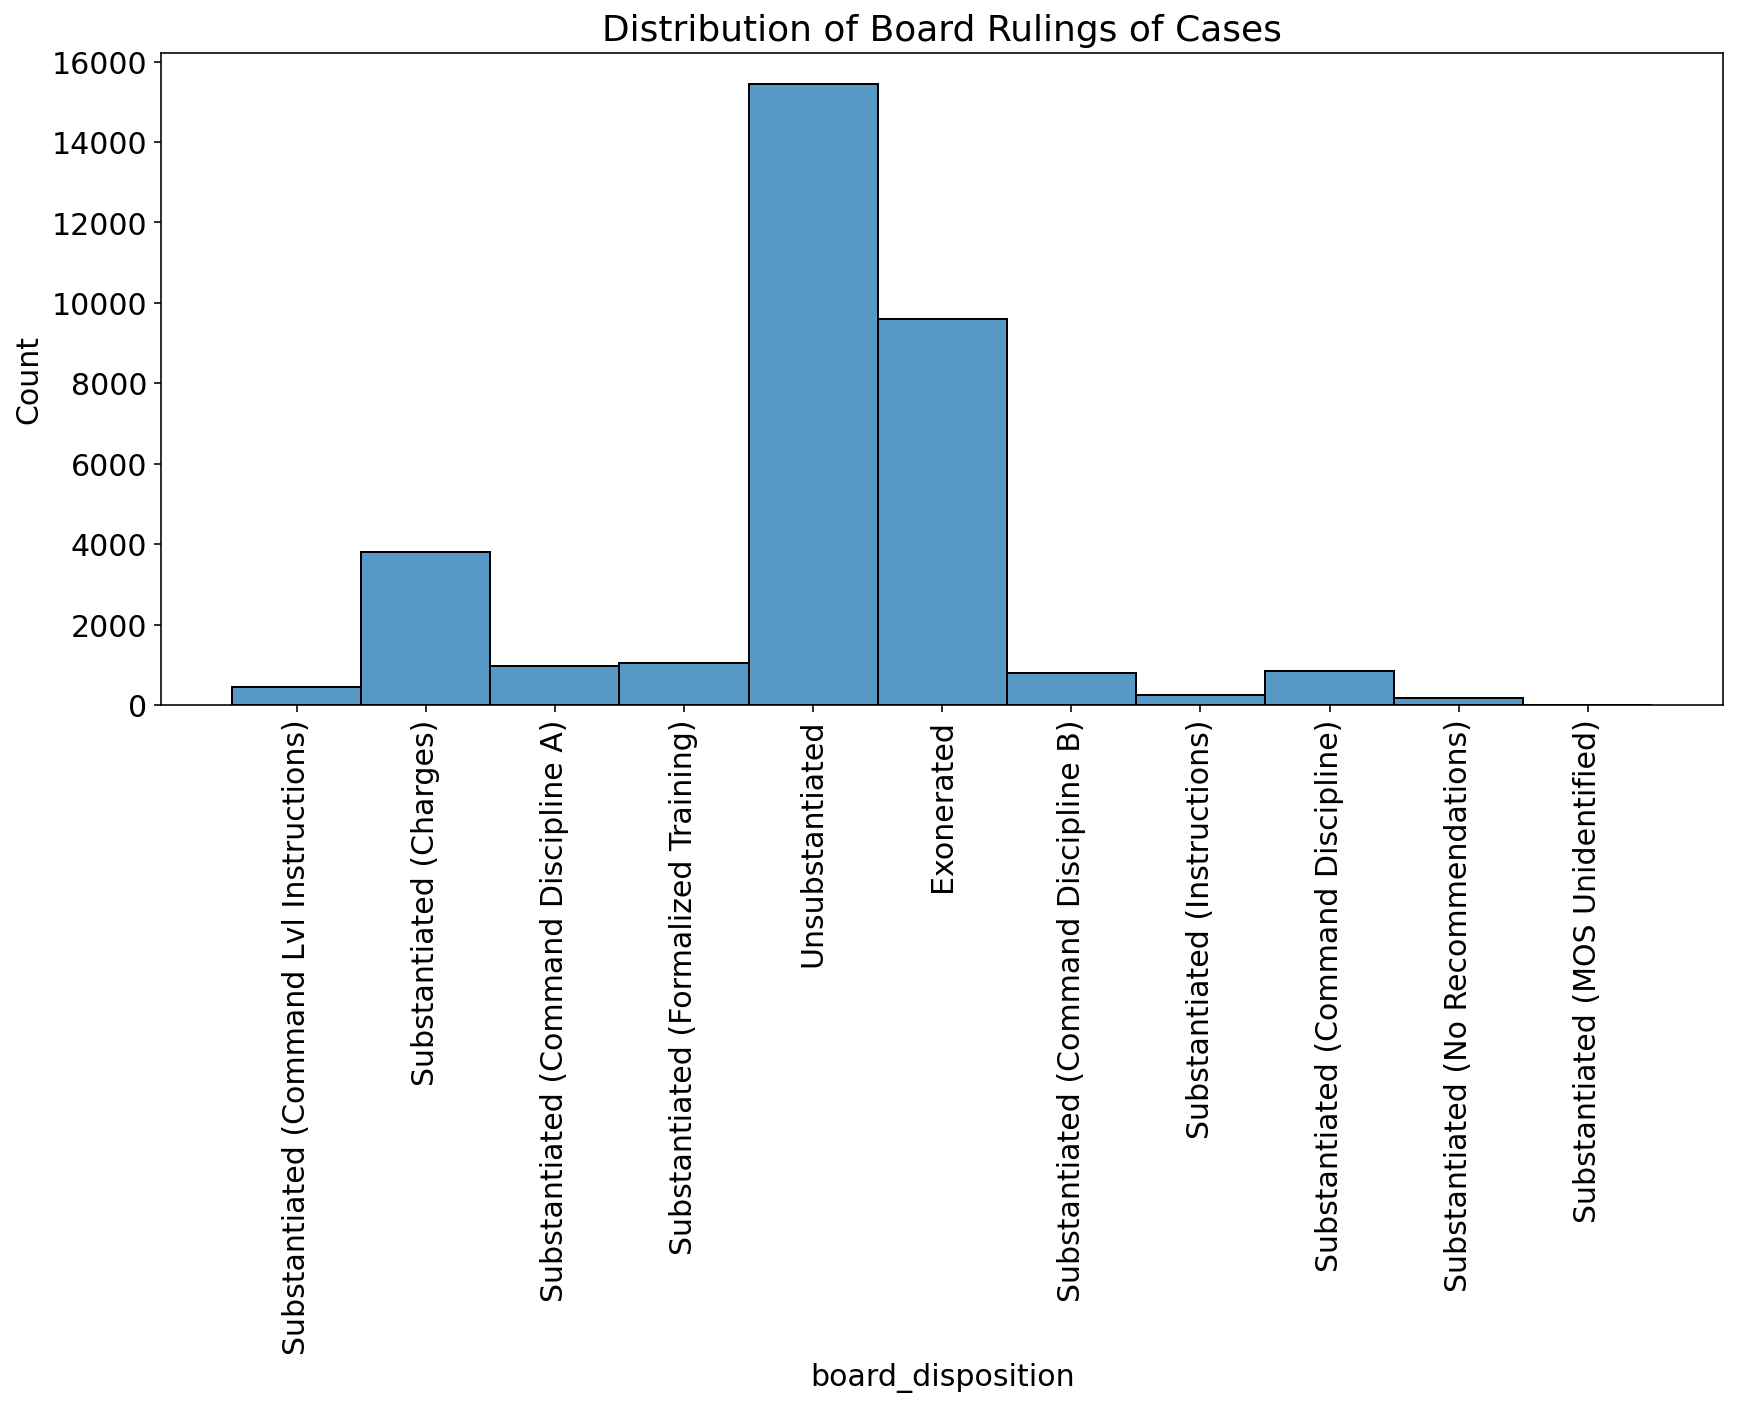

In [198]:
sns.histplot(df['board_disposition'])

plt.title('Distribution of Board Rulings of Cases')
plt.xticks(rotation = 90)
plt.show()

In [97]:
print('Proportion values:')
df['board_disposition'].value_counts(normalize = True)

Proportion values:


Unsubstantiated                             0.463097
Exonerated                                  0.288057
Substantiated (Charges)                     0.113796
Substantiated (Formalized Training)         0.030967
Substantiated (Command Discipline A)        0.028899
Substantiated (Command Discipline)          0.025511
Substantiated (Command Discipline B)        0.023652
Substantiated (Command Lvl Instructions)    0.013610
Substantiated (Instructions)                0.007434
Substantiated (No Recommendations)          0.004946
Substantiated (MOS Unidentified)            0.000030
Name: board_disposition, dtype: float64

Joining 'substantiated' cases together for easier visualization:

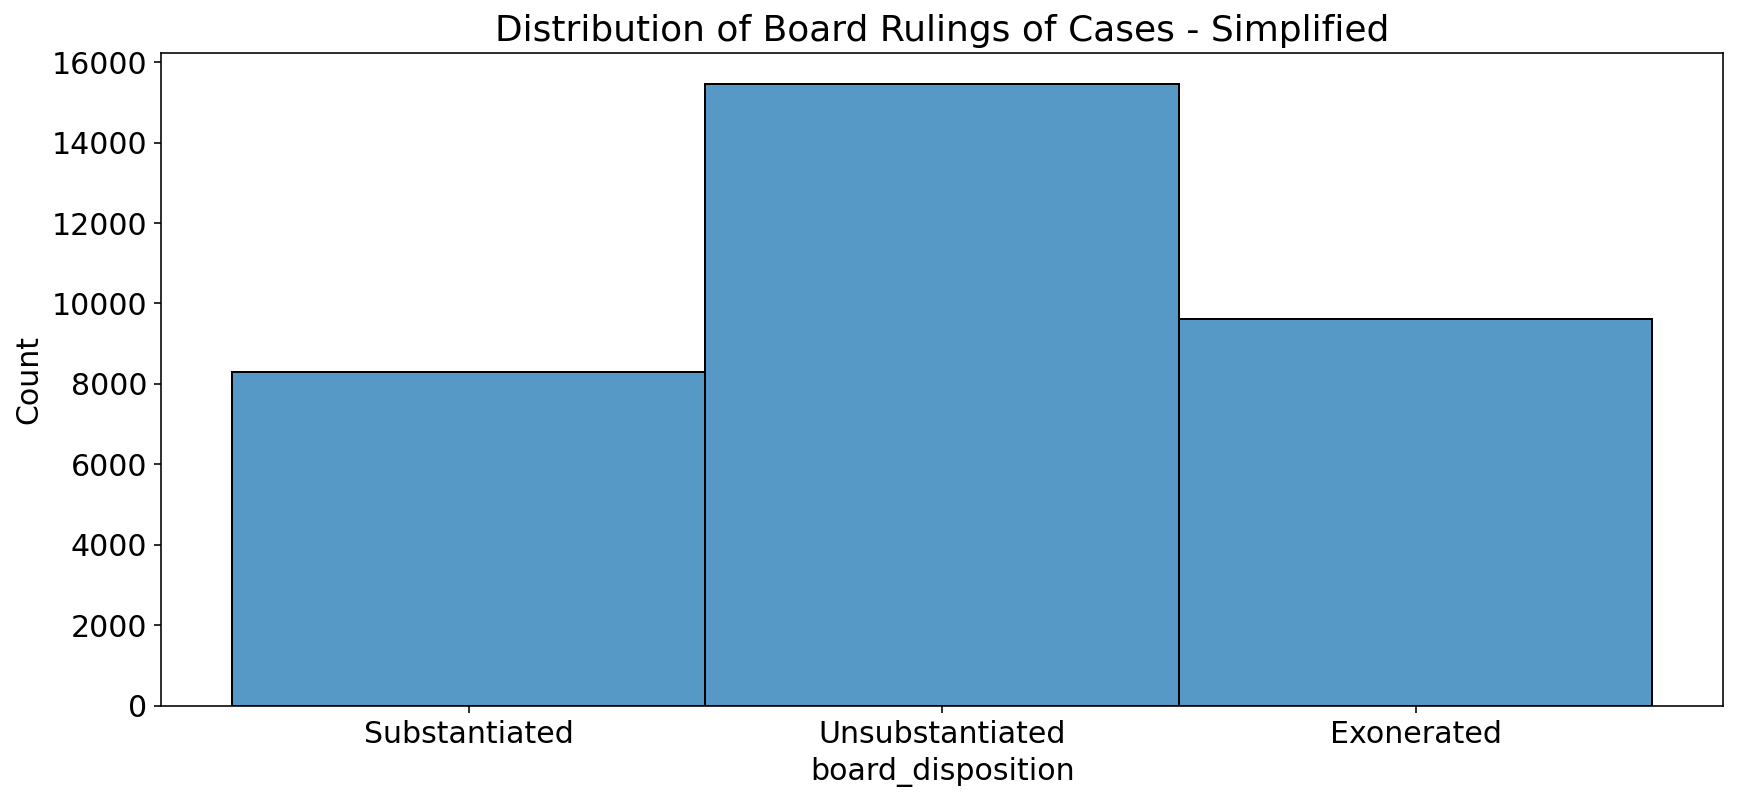

In [199]:
def group_substantiated(s):
    if 'Substantiated' in s:
        return 'Substantiated'
    else:
        return s

df.assign(board_disposition_simple = df['board_disposition'].apply(group_substantiated))

sns.histplot(df['board_disposition_simple'])

plt.title('Distribution of Board Rulings of Cases - Simplified')
plt.xlabel('board_disposition')
plt.show()

In [144]:
print('Proportion values:')
df['board_disposition_simple'].value_counts(normalize = True)

Proportion values:


Unsubstantiated    0.463097
Exonerated         0.288057
Substantiated      0.248846
Name: board_disposition_simple, dtype: float64

#### Bivariate Analysis

**Trends in officer gender vs complainant gender:**

The table below shows the proportions of the genders of complainants amongst complaints associated with male or female officers.

We can see that, amongst complaints with female officers, the frequency of male and female complainants are somewhat similar. The proportions do not add to 100%, which is due to missing data in the complainant gender category.

On the other hand, for complaints with male officers the frequency of male complainants is about 5 times higher than that of female complainants!

Furthermore, we can again see that there are our dataset has very few cases of complaints where the gender of the complainant was different from male or female.

In [179]:
pivot_counts = df.pivot_table(columns = 'mos_gender', 
               index = 'complainant_gender', 
               values = 'board_disposition', 
               aggfunc = 'count', 
               fill_value = 0)

num_female_officers = df.groupby('mos_gender')['board_disposition'].count().loc['F']
num_male_officers = df.groupby('mos_gender')['board_disposition'].count().loc['M']

pivot_counts.divide([num_female_officers, num_male_officers]).applymap(lambda x: round(x, 2))

mos_gender,F,M
complainant_gender,,
Female,0.35,0.14
Gender non-conforming,0.00,0.00
Male,0.55,0.73
Not described,0.00,0.00
Transman (FTM),0.00,0.00
Transwoman (MTF),0.00,0.00


**Trends in officer gender vs simplified board rulings:**

The table below shows the proportions of the final rulings of complainants amongst complaints associated with male or female officers.

We can see that there are different trends for male and female officers:

For male officers, unsubstantiated rulings are the most common, followed by exonerated, then substantiated. For female officers, unsubstantiated rulings are also the most common, however these are followed by substantiated ones and then exonerated.

This means that it is about 50% more common for female officers to be accused of violating the NYPD's rules of conduct than for male officers to be accused. 

Furthermore, it is slightly more likely for cases associated with male officers to be found unsubstantiated, where there is no conclusion, than for cases associated with female officers.

In [172]:
pivot_counts = df.pivot_table(columns = 'mos_gender', 
                              index = 'board_disposition_simple', 
                              values = 'board_disposition', 
                              aggfunc = 'count') 

num_female_officers = df.groupby('mos_gender')['board_disposition'].count().loc['F']
num_male_officers = df.groupby('mos_gender')['board_disposition'].count().loc['M']

pivot_proportions = pivot_counts.divide([num_female_officers, num_male_officers])

pivot_proportions.applymap(lambda x: round(x, 2))

mos_gender,F,M
board_disposition_simple,,
Exonerated,0.23,0.29
Substantiated,0.36,0.24
Unsubstantiated,0.41,0.47


The graphs below are graphical visualizations of the data described above:

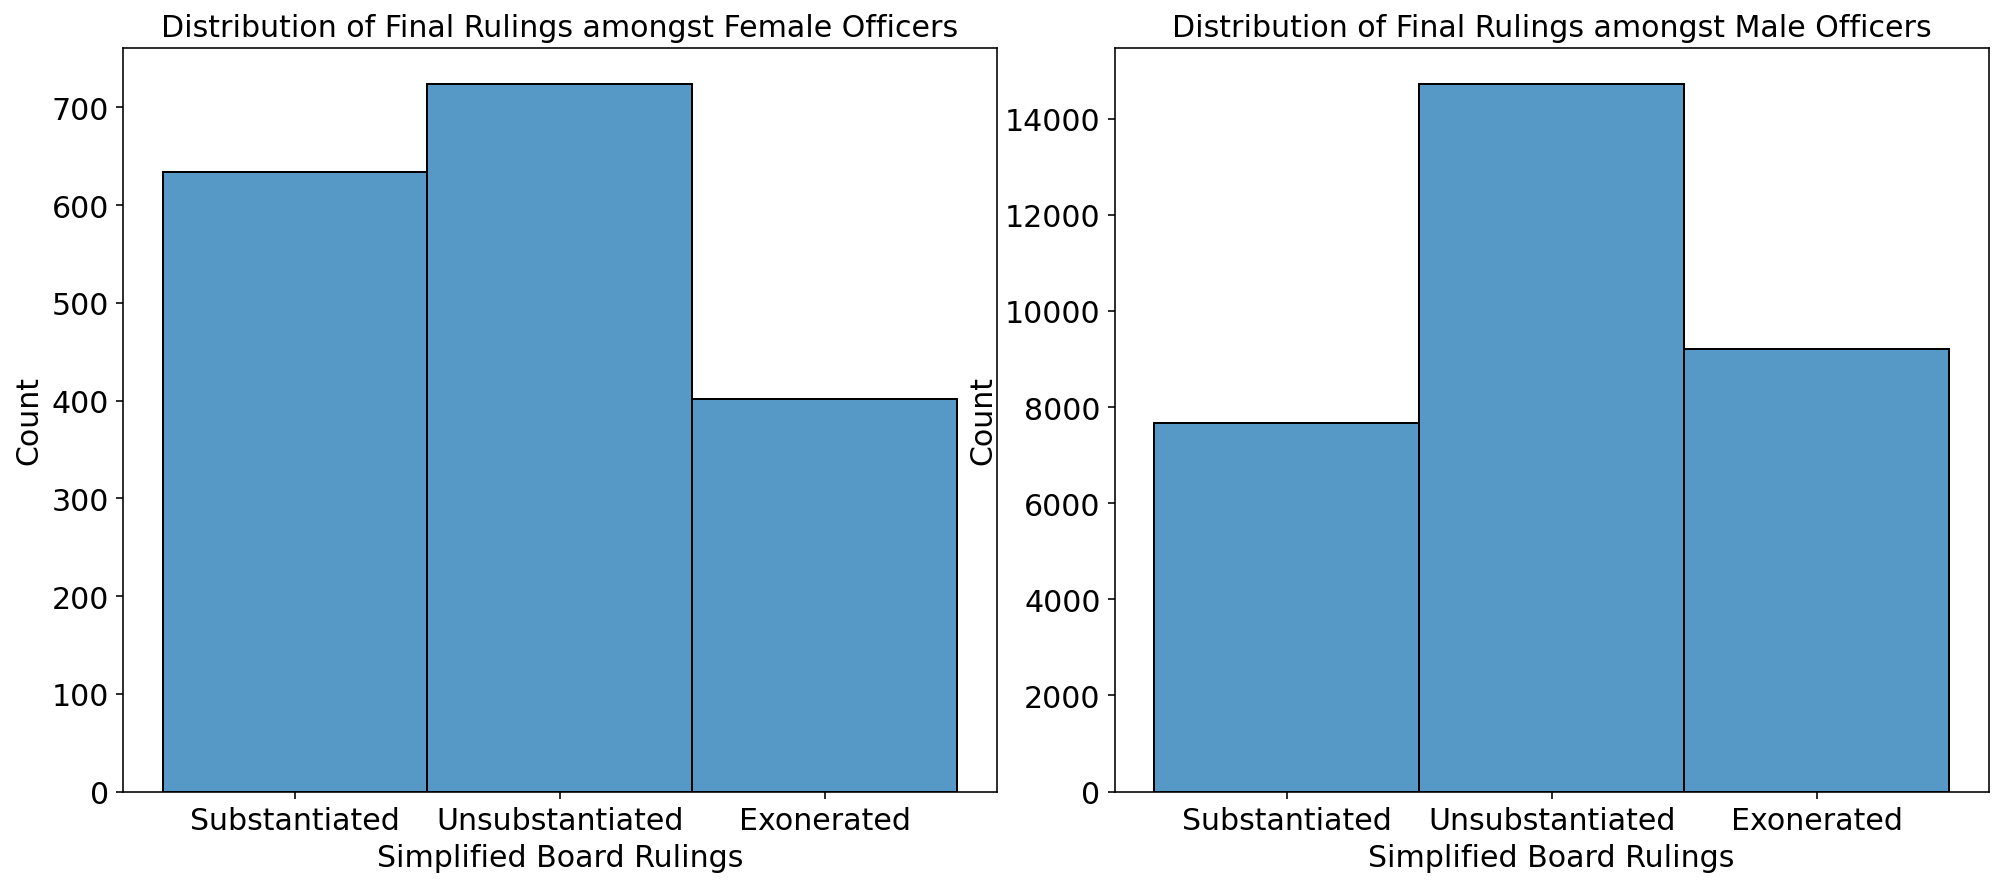

In [205]:
df_female_officers = df.loc[df['mos_gender'] == 'F']
df_male_officers = df.loc[df['mos_gender'] == 'M']

fig, axs = plt.subplots(1, 2)
fig.tight_layout()

sns.histplot(df_female_officers, x = 'board_disposition_simple', ax = axs[0])
axs[0].set_title('Distribution of Final Rulings amongst Female Officers', fontsize = 15)
axs[0].set_xlabel('Simplified Board Rulings')
sns.histplot(df_male_officers, x = 'board_disposition_simple', ax = axs[1])
axs[1].set_title('Distribution of Final Rulings amongst Male Officers', fontsize = 15)
axs[1].set_xlabel('Simplified Board Rulings')
plt.show()

**Trends in complainant gender vs simplified board rulings:**

The table below shows the proportions of the final rulings of complainants amongst complaints associated with male or female complainants. We decided to not investigate cases with other genders due to having a small sample of those.

We can see that female complainants have higher proportions of unsubstantiated and exonerated rulings, equalling lower proportions of substantiated rulings.

In [206]:
def is_male_female(s):
    if s in ['Male', 'Female']:
        return True
    else:
        return False

df_male_female_only = df.loc[df['complainant_gender'].apply(is_male_female)]

pivot_counts = df_male_female_only.pivot_table(columns = 'complainant_gender', 
                                               index = 'board_disposition_simple', 
                                               values = 'board_disposition', 
                                               aggfunc = 'count') 

num_female_complainants = df.groupby('complainant_gender')['board_disposition'].count().loc['Female']
num_male_complainants = df.groupby('complainant_gender')['board_disposition'].count().loc['Male']

pivot_proportions = pivot_counts.divide([num_female_complainants, num_male_complainants])

pivot_proportions.applymap(lambda x: round(x, 2))

complainant_gender,Female,Male
board_disposition_simple,,
Exonerated,0.28,0.27
Substantiated,0.21,0.26
Unsubstantiated,0.51,0.47


The graphs below are graphical visualizations of the data described above:

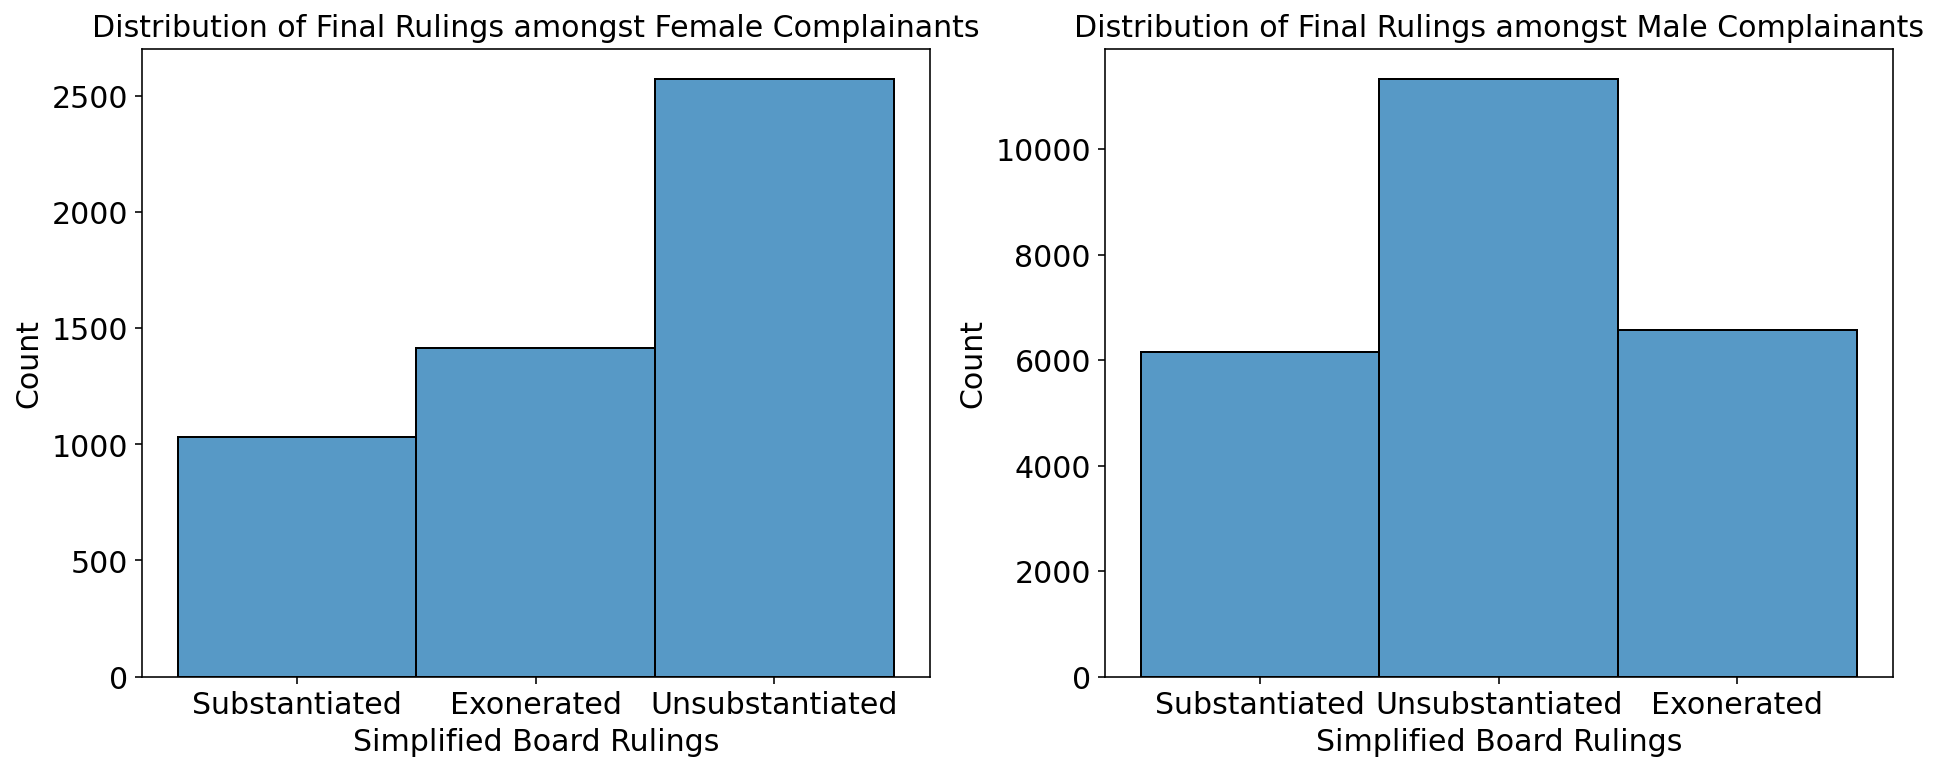

In [245]:
df_female_complainants = df.loc[df['complainant_gender'] == 'Female']
df_male_complainants = df.loc[df['complainant_gender'] == 'Male']

fig, axs = plt.subplots(1, 2)
fig.tight_layout(pad = 3)

sns.histplot(df_female_complainants, x = 'board_disposition_simple', ax = axs[0])
axs[0].set_title('Distribution of Final Rulings amongst Female Complainants', fontsize = 15)
axs[0].set_xlabel('Simplified Board Rulings')
sns.histplot(df_male_complainants, x = 'board_disposition_simple', ax = axs[1])
axs[1].set_title('Distribution of Final Rulings amongst Male Complainants', fontsize = 15)
axs[1].set_xlabel('Simplified Board Rulings')
plt.show()

In order to go a bit deeper, we would like to see if this trend still holds across complaint categories.

The table below shows the proportions of each top-level category of complaint by gender of complainant. 

We can see that there is some variation between male and female complainants. Female complaints are proportionally more to do with 'discourtesy' and 'offensive language' than male complaints. On the other hand, male complaints are made up more of 'abuse of authority' and 'force' complaints.

In [213]:
#First, add categories back into df
df[['fado_type', 'allegation']] = df_full[['fado_type', 'allegation']]

In [218]:
#Keep male and female complainants only for simplicity
df_male_female_only = df.loc[df['complainant_gender'].apply(is_male_female)]

#Create pivot table
pivot_counts = df_male_female_only.pivot_table(columns = 'complainant_gender',
              index = 'fado_type',
              values = 'mos_gender',
              aggfunc = 'count')

num_female_complainants = df.groupby('complainant_gender')['board_disposition'].count().loc['Female']
num_male_complainants = df.groupby('complainant_gender')['board_disposition'].count().loc['Male']

#Divide columns of pivot table by column totals
pivot_proportions = pivot_counts.divide([num_female_complainants, num_male_complainants])

pivot_proportions.applymap(lambda x: round(x, 2))

complainant_gender,Female,Male
fado_type,,
Abuse of Authority,0.55,0.61
Discourtesy,0.20,0.13
Force,0.21,0.24
Offensive Language,0.04,0.02


Computing the same proportions as before - that is, the proportions of different ruling outcomes by complainant gender - but, this time, within each category of complaint at a time.

The table below shows those proportions for complaint type 'Abuse of Authority':

In [223]:
df_male_female_only_abuse = df_male_female_only.loc[df_male_female_only['fado_type'] == 'Abuse of Authority']

pivot_counts = df_male_female_only_abuse.pivot_table(columns = 'complainant_gender', 
                                               index = 'board_disposition_simple', 
                                               values = 'board_disposition', 
                                               aggfunc = 'count') 

num_female_complainants = df_male_female_only_abuse.groupby('complainant_gender')['board_disposition'].count().loc['Female']
num_male_complainants = df_male_female_only_abuse.groupby('complainant_gender')['board_disposition'].count().loc['Male']

pivot_proportions = pivot_counts.divide([num_female_complainants, num_male_complainants])

pivot_proportions.applymap(lambda x: round(x, 2))

complainant_gender,Female,Male
board_disposition_simple,,
Exonerated,0.28,0.25
Substantiated,0.26,0.32
Unsubstantiated,0.46,0.43


The table below shows those proportions for complaint type 'Discourtesy':

In [224]:
df_male_female_only_discourtesy = df_male_female_only.loc[df_male_female_only['fado_type'] == 'Discourtesy']

pivot_counts = df_male_female_only_abuse.pivot_table(columns = 'complainant_gender', 
                                               index = 'board_disposition_simple', 
                                               values = 'board_disposition', 
                                               aggfunc = 'count') 

num_female_complainants = df_male_female_only_abuse.groupby('complainant_gender')['board_disposition'].count().loc['Female']
num_male_complainants = df_male_female_only_abuse.groupby('complainant_gender')['board_disposition'].count().loc['Male']

pivot_proportions = pivot_counts.divide([num_female_complainants, num_male_complainants])

pivot_proportions.applymap(lambda x: round(x, 2))

complainant_gender,Female,Male
board_disposition_simple,,
Exonerated,0.28,0.25
Substantiated,0.26,0.32
Unsubstantiated,0.46,0.43


The table below shows those proportions for complaint type 'Force':

In [225]:
df_male_female_only_force = df_male_female_only.loc[df_male_female_only['fado_type'] == 'Force']

pivot_counts = df_male_female_only_abuse.pivot_table(columns = 'complainant_gender', 
                                               index = 'board_disposition_simple', 
                                               values = 'board_disposition', 
                                               aggfunc = 'count') 

num_female_complainants = df_male_female_only_abuse.groupby('complainant_gender')['board_disposition'].count().loc['Female']
num_male_complainants = df_male_female_only_abuse.groupby('complainant_gender')['board_disposition'].count().loc['Male']

pivot_proportions = pivot_counts.divide([num_female_complainants, num_male_complainants])

pivot_proportions.applymap(lambda x: round(x, 2))

complainant_gender,Female,Male
board_disposition_simple,,
Exonerated,0.28,0.25
Substantiated,0.26,0.32
Unsubstantiated,0.46,0.43


The table below shows those proportions for complaint type 'Offensive Language':

In [226]:
df_male_female_only_offLang = df_male_female_only.loc[df_male_female_only['fado_type'] == 'Offensive Language']

pivot_counts = df_male_female_only_abuse.pivot_table(columns = 'complainant_gender', 
                                               index = 'board_disposition_simple', 
                                               values = 'board_disposition', 
                                               aggfunc = 'count') 

num_female_complainants = df_male_female_only_abuse.groupby('complainant_gender')['board_disposition'].count().loc['Female']
num_male_complainants = df_male_female_only_abuse.groupby('complainant_gender')['board_disposition'].count().loc['Male']

pivot_proportions = pivot_counts.divide([num_female_complainants, num_male_complainants])

pivot_proportions.applymap(lambda x: round(x, 2))

complainant_gender,Female,Male
board_disposition_simple,,
Exonerated,0.28,0.25
Substantiated,0.26,0.32
Unsubstantiated,0.46,0.43


Making visualizations:

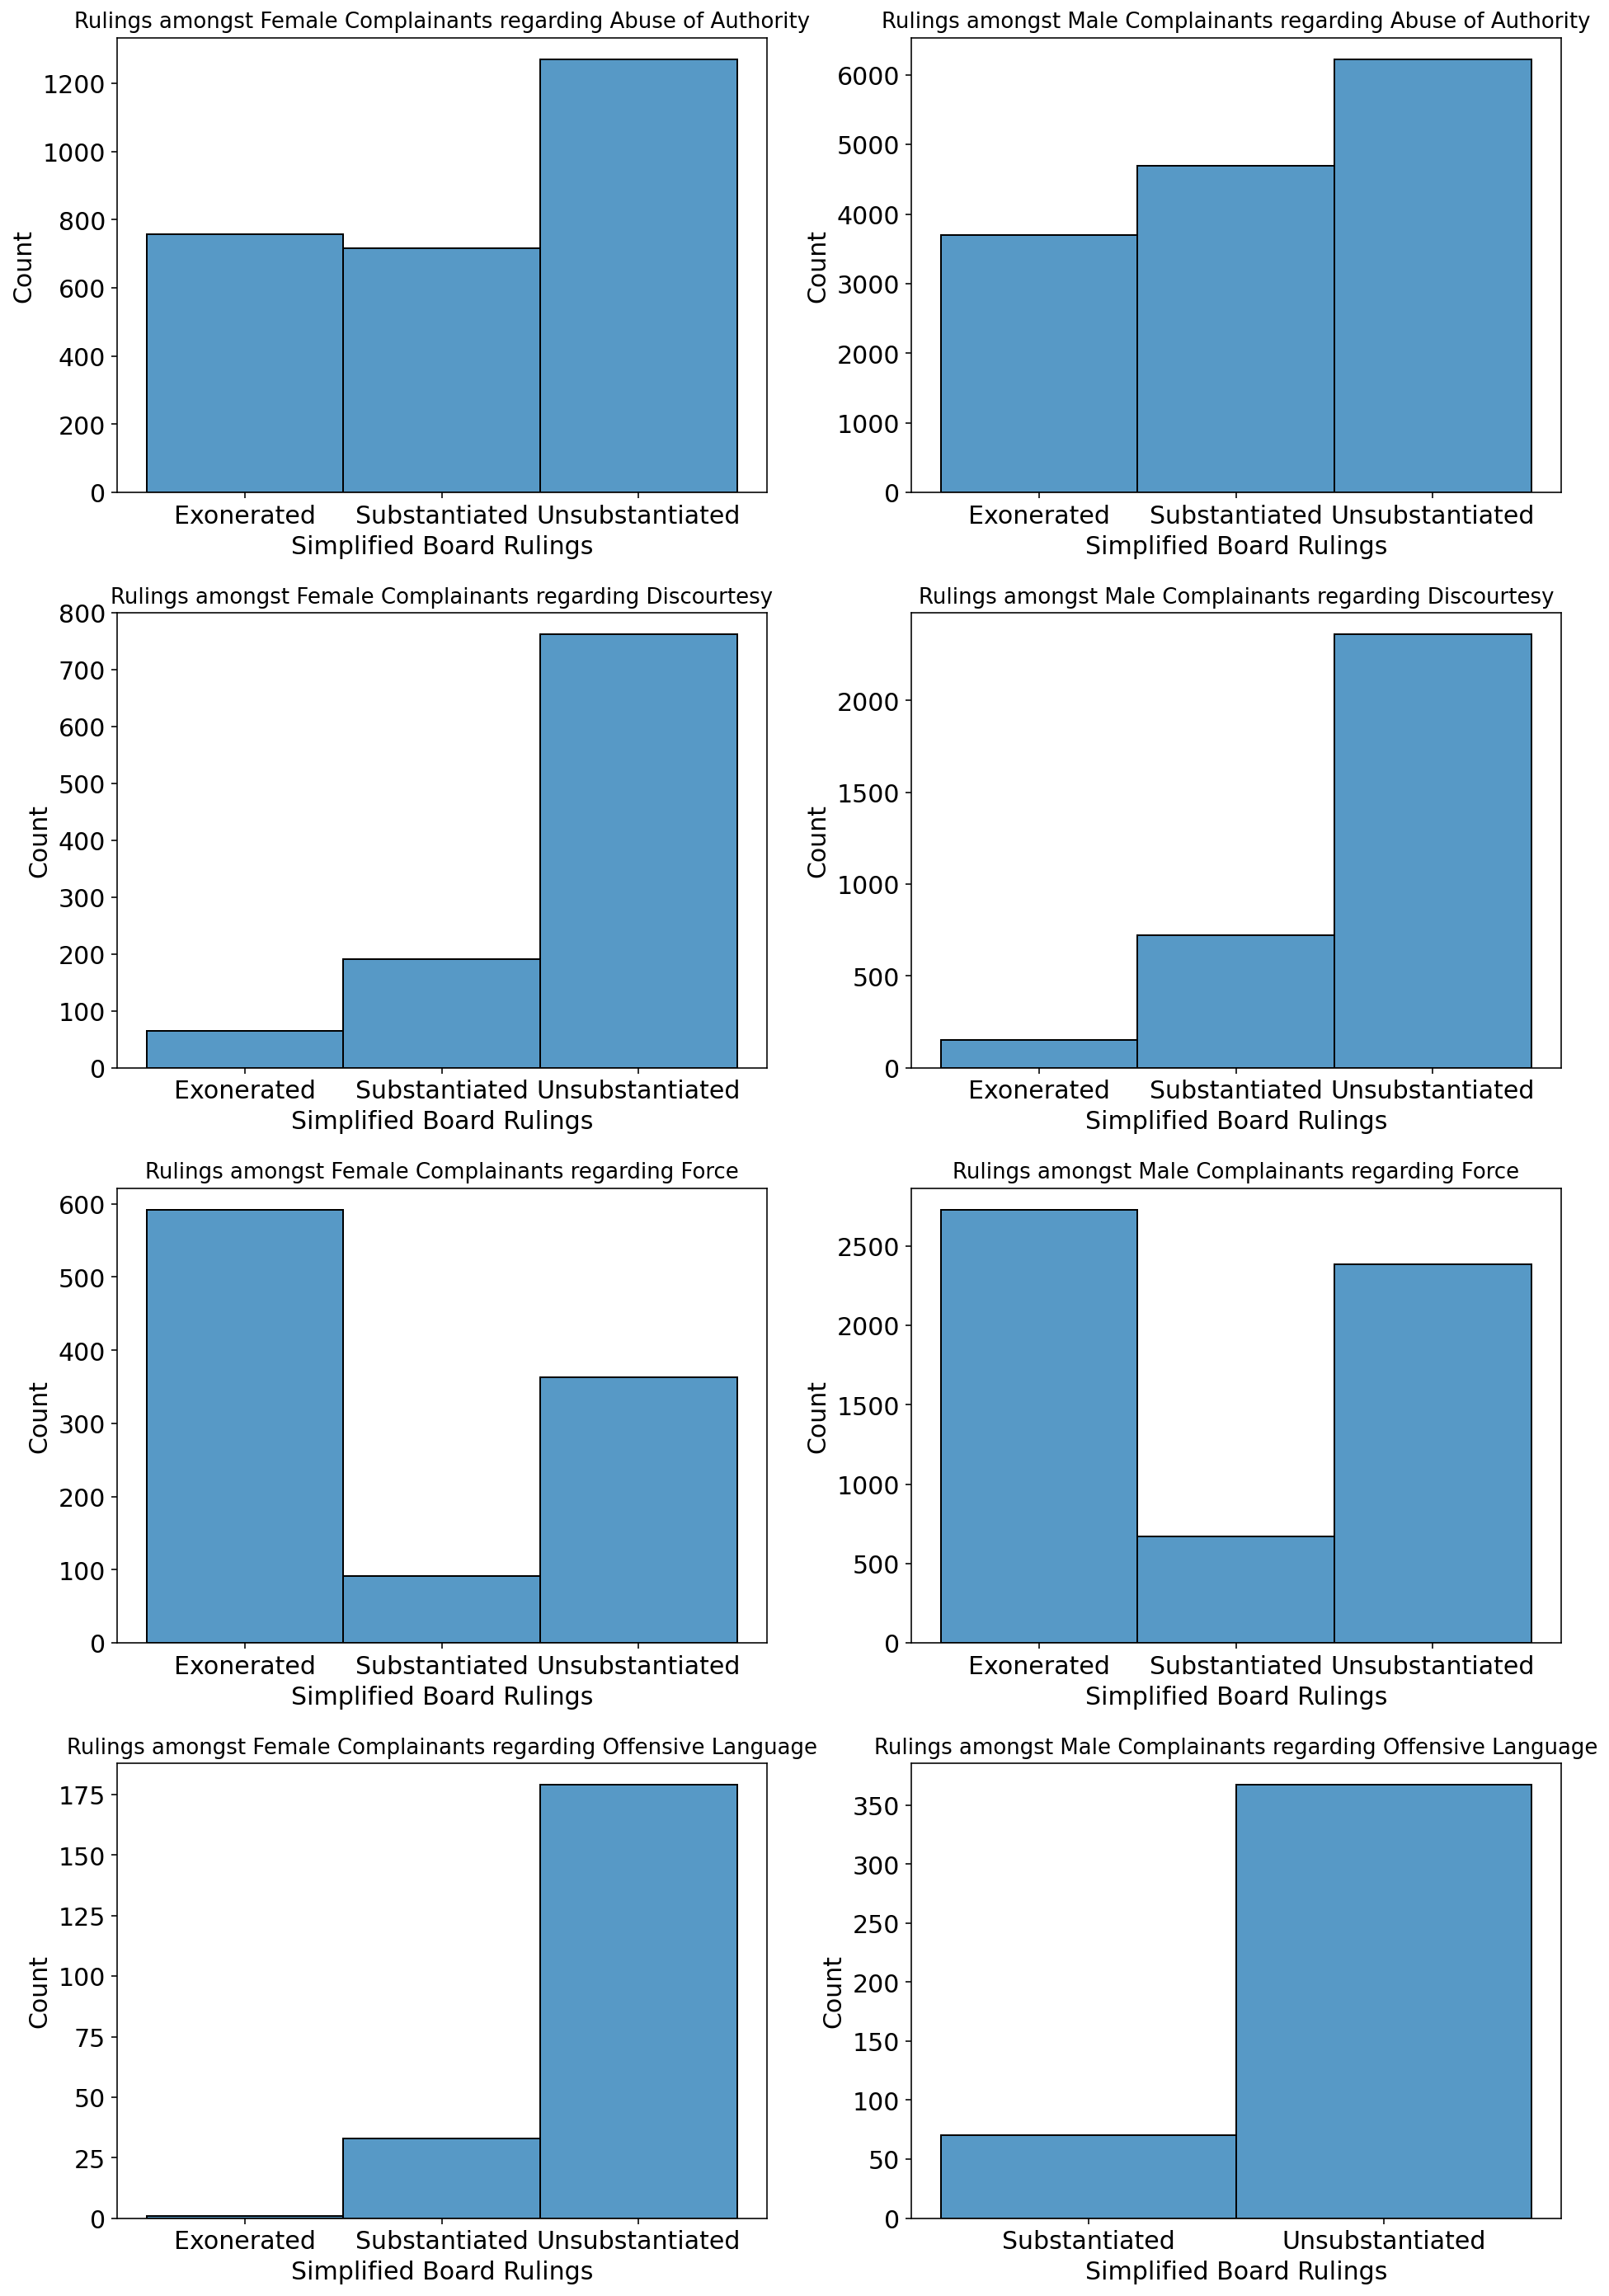

In [246]:
#Creating boolean vectors to filter each one of the 8 groups
female_abuse = (df['complainant_gender'] == 'Female') & (df['fado_type'] == 'Abuse of Authority')
male_abuse = (df['complainant_gender'] == 'Male') & (df['fado_type'] == 'Abuse of Authority')

female_discourtesy = (df['complainant_gender'] == 'Female') & (df['fado_type'] == 'Discourtesy')
male_discourtesy = (df['complainant_gender'] == 'Male') & (df['fado_type'] == 'Discourtesy')

female_force = (df['complainant_gender'] == 'Female') & (df['fado_type'] == 'Force')
male_force = (df['complainant_gender'] == 'Male') & (df['fado_type'] == 'Force')

female_offLang = (df['complainant_gender'] == 'Female') & (df['fado_type'] == 'Offensive Language')
male_offLang = (df['complainant_gender'] == 'Male') & (df['fado_type'] == 'Offensive Language')

#Put them all in a list to facilitate looping:
bool_arrs = [female_abuse, male_abuse, female_discourtesy, male_discourtesy, 
             female_force, male_force, female_offLang, male_offLang]


fig, axs = plt.subplots(4, 2, figsize = (14, 20))
fig.tight_layout(pad=3)

#Loop over 'filtering' bool arrays and make visualizations for each
for bool_arr, ax in zip(bool_arrs, axs.flatten()):
    
    df_filtered = df.loc[bool_arr].sort_values(by = 'board_disposition_simple')
    
    sns.histplot(df_filtered, x = 'board_disposition_simple', ax = ax)
    
    ax.set_xlabel('Simplified Board Rulings')
    

axs[0][0].set_title('Rulings amongst Female Complainants regarding Abuse of Authority', fontsize = 13)
axs[0][1].set_title('Rulings amongst Male Complainants regarding Abuse of Authority', fontsize = 13)
axs[1][0].set_title('Rulings amongst Female Complainants regarding Discourtesy', fontsize = 13)
axs[1][1].set_title('Rulings amongst Male Complainants regarding Discourtesy', fontsize = 13)
axs[2][0].set_title('Rulings amongst Female Complainants regarding Force', fontsize = 13)
axs[2][1].set_title('Rulings amongst Male Complainants regarding Force', fontsize = 13)
axs[3][0].set_title('Rulings amongst Female Complainants regarding Offensive Language', fontsize = 13)
axs[3][1].set_title('Rulings amongst Male Complainants regarding Offensive Language', fontsize = 13)


plt.show()

By comparing the graphs side-by-side or looking at the tables, it can be seen that, regardless of the category of the complaint, female complainants have lower rates of substantiated complaints than male complainants.

### Assessment of Missingness

The following cell counts the number of missing values in each column of our reduced dataframe. We can ignore the single missing value in the 'allegation' column, but 4195 missing values in 'complainant_gender' is quite relevant. We want to understand what kind of missingness mechanism is behind this missingness.

In [255]:
df.isna().sum()

mos_gender                     0
complainant_gender          4195
board_disposition              0
board_disposition_simple       0
fado_type                      0
allegation                     1
dtype: int64

First, we can quickly check for some trends - maybe we can spot if it is missing by design or clearly MAR:

In [267]:
df.loc[df['complainant_gender'].isna()]['mos_gender'].value_counts(normalize = True)

M    0.960667
F    0.039333
Name: mos_gender, dtype: float64

In [269]:
df.loc[df['complainant_gender'].isna()]['board_disposition_simple'].value_counts(normalize = True)

Exonerated         0.380930
Unsubstantiated    0.359476
Substantiated      0.259595
Name: board_disposition_simple, dtype: float64

In [270]:
df.loc[df['complainant_gender'].isna()]['fado_type'].value_counts(normalize = True)

Abuse of Authority    0.688439
Force                 0.189511
Discourtesy           0.099166
Offensive Language    0.022884
Name: fado_type, dtype: float64

In [271]:
df.loc[df['complainant_gender'].isna()]['allegation'].value_counts(normalize = True)

Premises entered and/or searched    0.364092
Entry of Premises                   0.059132
Curse                               0.047687
Push/Shove                          0.041965
Gun Drawn                           0.040534
                                      ...   
Demeanor/tone                       0.000238
Sexist Remark                       0.000238
Interference with recording         0.000238
Refusal to provide name             0.000238
Gesture                             0.000238
Name: allegation, Length: 85, dtype: float64

It does not seem like there is a single value in the other columns that could be completely explaining the missingness of complainant genders. However, the values for 'fado_type' = 'Abuse of Authority' seem quite high, and the gender of the officers in question seem to be disproportionately male.

Let's compare these columns to the values in the non-missing data:

#### MAR with relation to officer gender?

The first table of values shows the proportions of male and female officers for the non-missing complainant genders, while the second shows the proportions of male and female officers for the missing ones. The difference does not appear to be very large, although this could be significant given our large sample size.

In [272]:
df.loc[np.logical_not(df['complainant_gender'].isna())]['mos_gender'].value_counts(normalize = True)

M    0.945307
F    0.054693
Name: mos_gender, dtype: float64

In [273]:
df.loc[df['complainant_gender'].isna()]['mos_gender'].value_counts(normalize = True)

M    0.960667
F    0.039333
Name: mos_gender, dtype: float64

Let's run a permutation test to verify. Our test statistic will be the TVD since we are working with proportions of a categorical variable.

In [343]:
#Assign a column to df indicating whether gender is missing or not
df = df.assign(cg_missing = df['complainant_gender'].isna())

In [400]:
#Define our test statistic
def TVD(arr1, arr2):
    
    # If one array has a different length from the other,
    # this means that one of the unique values was not
    # seen in one of the conditions (gender missing or not)
    # after shuffling.
    # Here, we make the arrays the same length by filling
    # in with zeroes so that we can run permutation tests
    # for slightly more complex cases:
    if len(arr1) > len(arr2):
        len_diff = len(arr1) - len(arr2)
        for _ in range(len_diff):
            arr2 = np.append(0, arr2)
    else:
        len_diff = len(arr2) - len(arr1)
        for _ in range(len_diff):
            arr1 = np.append(0, arr1)
        
    #Calculate and return TVD
    return np.sqrt(np.sum(abs(arr1 - arr2) ** 2))

def observed_test_stat(df_copy, group_column, test_column):
    #Get the number of unique values in test_column whether complainant gender is missing or not
    totals = df_copy.groupby(group_column)[test_column].value_counts(normalize = True)
    missing = np.array(totals.loc[True])
    not_missing = np.array(totals.loc[False])
    
    #Calculate observed test statistic
    obs = TVD(missing, not_missing)
    return obs

def run_permutations_for_missingness(data, group_column, test_column, N = 1000):
    df_copy = data.copy()
    
    obs = observed_test_stat(df_copy, group_column, test_column)
    
    test_stats = np.array([])

    for _ in range(N):

        #Shuffle the test_column to generate a possible dataset under the null hypothesis
        df_copy[test_column] = df_copy[test_column].sample(replace = False, frac = 1).reset_index(drop = True)

        #Get the proportions of unique values in test_column whether complainant gender is missing or not
        totals = df_copy.groupby(group_column)[test_column].value_counts(normalize = True)
        missing = np.array(totals.loc[True])
        not_missing = np.array(totals.loc[False])

        #Calculate test statistic under null
        test_stat = TVD(missing, not_missing)
        test_stats = np.append(test_stat, test_stats)

    #Calculate p-value from simulations
    p = np.count_nonzero(test_stats >= obs) / N
    
    return (test_stats, p)

In [389]:
test_stats, p = run_permutations_for_missingness(df, 'cg_missing', 'mos_gender')

In [390]:
print(f"p-value: {p}")

p-value: 0.0


We have an extremely low p-value. It is in fact 0 because none of our simulated distributions were as different from eachother as our observations were. The plot below shows this visually:

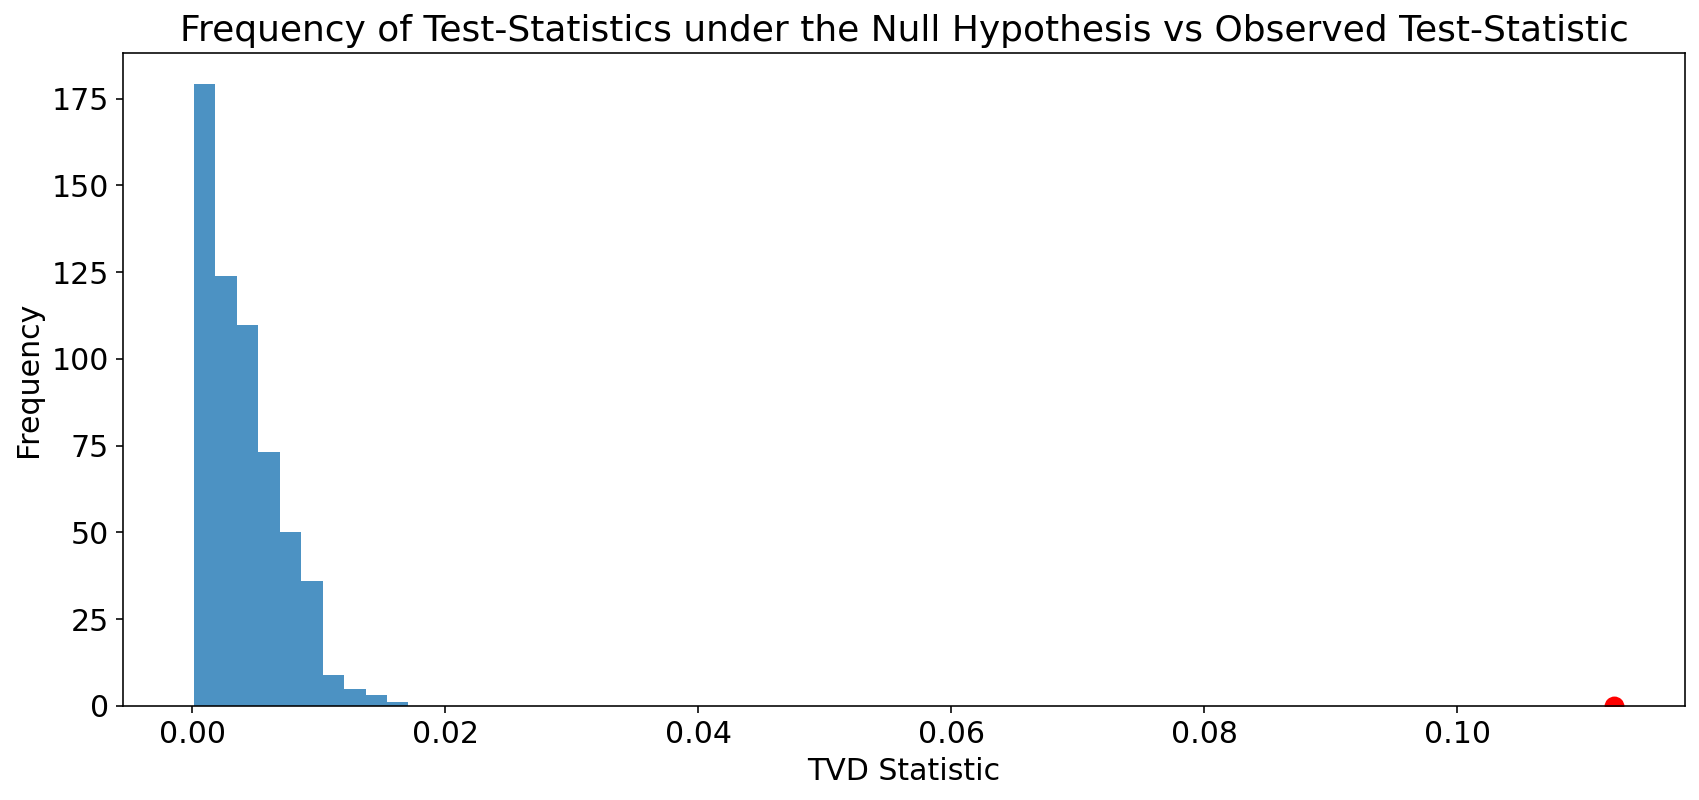

In [391]:
pd.Series(test_stats).plot(kind='hist', density=True, alpha=0.8)
plt.scatter(obs, 0, color='red', s=80);
plt.title('Frequency of Test-Statistics under the Null Hypothesis vs Observed Test-Statistic')
plt.xlabel('TVD Statistic')
plt.show()

#### MAR with relation to complaint category?

The first table of values shows the proportions of each complaint category for the non-missing complainant genders, while the second shows the same proportions for the missing complainant genders. Here, the differences appear to be larger, but this could still be explainable given the larger number of categories.

In [392]:
df.loc[np.logical_not(df['complainant_gender'].isna())]['fado_type'].value_counts(normalize = True)

Abuse of Authority    0.596784
Force                 0.234578
Discourtesy           0.146110
Offensive Language    0.022529
Name: fado_type, dtype: float64

In [393]:
df.loc[df['complainant_gender'].isna()]['fado_type'].value_counts(normalize = True)

Abuse of Authority    0.688439
Force                 0.189511
Discourtesy           0.099166
Offensive Language    0.022884
Name: fado_type, dtype: float64

Let's run a permutation test to verify. Our test statistic will again be the TVD.

In [394]:
test_stats, p = run_permutations_for_missingness(df, 'cg_missing', 'fado_type')

In [395]:
print(f"p-value: {p}")

p-value: 0.0


We again have an extremely low p-value. The plot below shows this visually. This time, our observations are even more extreme.

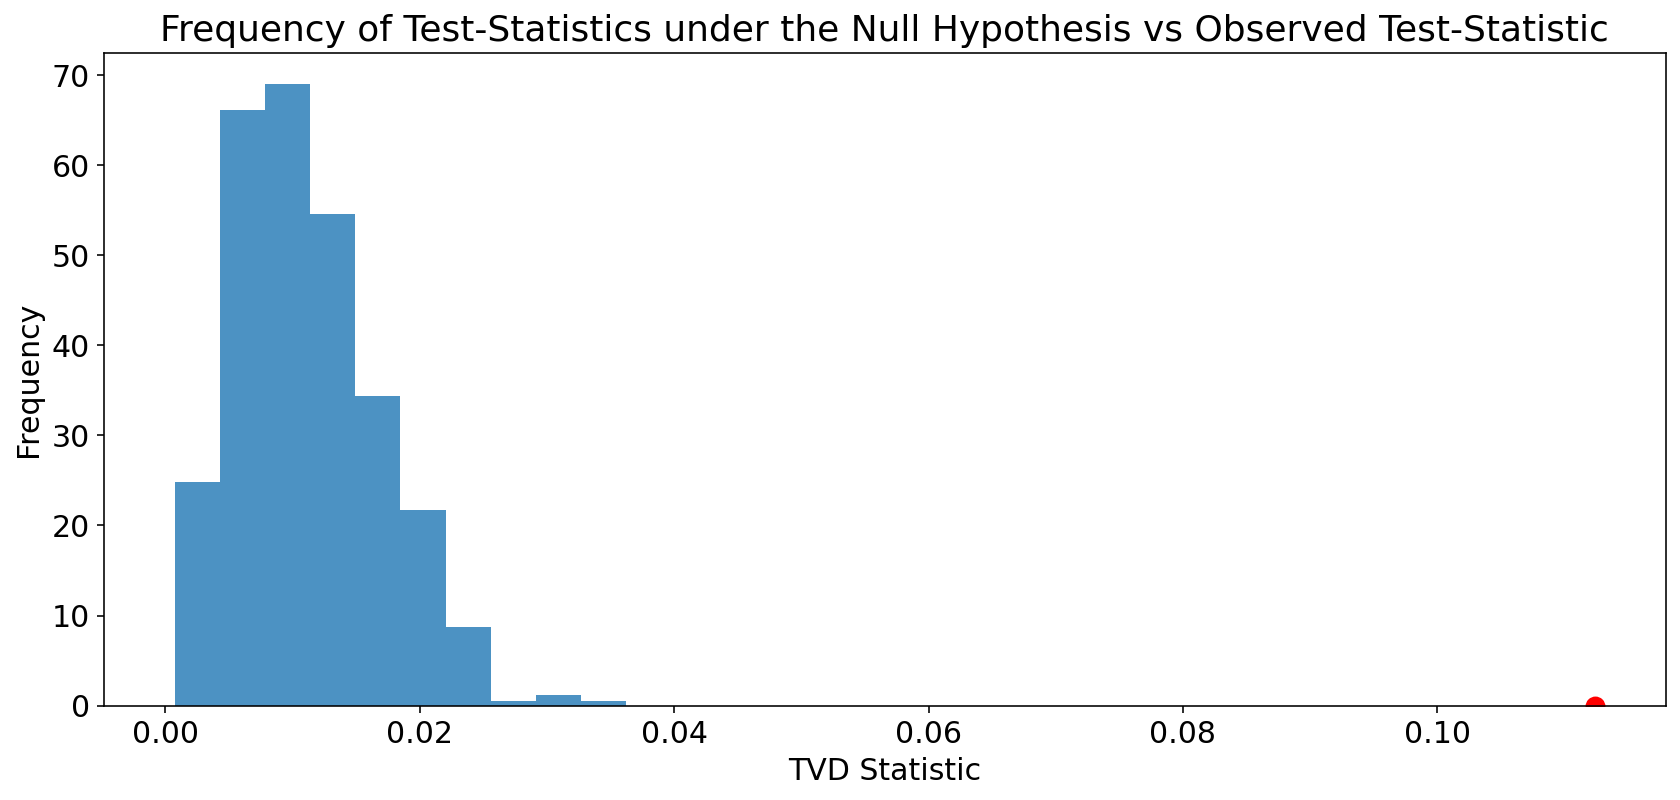

In [396]:
pd.Series(test_stats).plot(kind='hist', density=True, alpha=0.8)
plt.scatter(obs, 0, color='red', s=80);
plt.title('Frequency of Test-Statistics under the Null Hypothesis vs Observed Test-Statistic')
plt.xlabel('TVD Statistic')
plt.show()

#### What about MAR dependent on other features?

Since we saw these very extreme p-values, we thought it would be interesting to check if the missingness of the complainant gender was also dependent on the other categorical columns of our dataset. This is quite simple using the functions we defined for running permutation tests.

We cannot do this for all categorical columns since some of them might not have enough samples for each unique value for a good test. The 'command_at_incident' variable is an example of this. There are 157 unique values in the column that were seen less than 10 times:

In [397]:
df_full['command_at_incident'].value_counts()[df_full['command_at_incident'].value_counts() < 10]

067 DET    9
TB ATU     9
PBQS AC    9
TB DT11    9
B/S-WND    9
          ..
OMAP       1
032 DET    1
GANG DV    1
026 DET    1
BX CT      1
Name: command_at_incident, Length: 157, dtype: int64

For other categorical columns with higher unique value frequencies, however, we can try:

In [402]:
categorical_cols = ['mos_ethnicity', 'complainant_ethnicity', 'allegation', 
                    'contact_reason', 'board_disposition', 'complainant_gender']

df_cat = df_full[categorical_cols]
df_cat = df_cat.assign(cg_missing = df_cat['complainant_gender'].isna())

We can run permutation tests to check for MAR with relation to each column inside a for loop:

In [404]:
for c in categorical_cols[:-1]:
    _, p = run_permutations_for_missingness(df_cat, 'cg_missing', c)
    print(f"p-value for {c}: {p}")

p-value for mos_ethnicity: 0.013
p-value for complainant_ethnicity: 0.0
p-value for allegation: 0.0
p-value for contact_reason: 0.912
p-value for board_disposition: 1.0


#### Assessment of Missingness Conclusions:

We can see that there is good chance to believe that the fact that a complainant's gender is missing depends on the gender and ethnicity of the officer, the ethnicity of the complainant, and the category and specific allegation of the complaint.

### Hypothesis Test

We would like to verify if the rate at which complaints are found substantiated is the same for female complainants against male officers as it is for male complainants against male officers.

For this, we will conduct a hypothesis test under the following null and alternatives:

Null: Proportion of substantiated cases is **equal** for male-offcer vs male-complainant cases and male-officer vs female-complainant cases

Alternative: Proportion of substantiated cases is **not equal** for male-offcer vs male-complainant cases and male-officer vs female-complainant cases

Since the missingness mechanism appears to be quite complex, we will just drop null values:

In [415]:
df = df.dropna()

We also only want to keep cases where the officer was male and the complainant was either male or female.

In [418]:
df = df[df['mos_gender'] == 'M']
df = df[(df['complainant_gender'] == 'Female') | (df['complainant_gender'] == 'Male')]

Let's first do some EDA to see which hypothesis test we should run. The table below shows the proportion of substantiated cases for female complainants vs male complainants. Please note that these only include cases for male officers.

In [426]:
df.groupby('complainant_gender')['board_disposition_simple'].value_counts(normalize = True).loc[:, 'Substantiated']

complainant_gender
Female    0.189871
Male      0.250054
Name: board_disposition_simple, dtype: float64

There is a pretty large disparity between these. To run a hypthesis test, we can simply use the difference in the proportions for male and female complainants as our test statistic. Then, we can run a permutation test to check this difference for statistical significance. We decide to use a statistical significance level of 0.05.

Now we run our permutation test. We are grouping by complainant_gender and running our test statistics on the proportions substantiated cases.

In [447]:
#Get proportions of case outcomes by complainant gender
proportions =  df.groupby('complainant_gender')['board_disposition_simple'].value_counts(normalize = True)
proportions_substantiated = proportions.loc[:, 'Substantiated']

#Get proportion of substantiated cases for either female or male complainants
female = proportions_substantiated.loc['Female']
male = proportions_substantiated.loc['Male']

#Calculate observed test statistic
obs = abs(male - female)

#Copy dataframe to facilitate shuffling without messing with df
df_copy = df.copy()

#Set number of permutations
N = 1000

test_stats = np.array([])

#Run permutations under null
for _ in range(N):
    
    df_copy = df.copy()

    #Shuffle the test_column to generate a possible dataset under the null hypothesis
    df_copy['board_disposition_simple'] = df_copy[
        'board_disposition_simple'].sample(replace = False, frac = 1).reset_index(drop = True)

    #Get proportions of case outcomes by complainant gender
    proportions =  df_copy.groupby('complainant_gender')['board_disposition_simple'].value_counts(normalize = True)
    proportions_substantiated = proportions.loc[:, 'Substantiated']

    #Get proportion of substantiated cases for either female or male complainants
    #Due to nature of random shuffling, it is possible for there to be 0 substantiated
    #cases for one of the genders. In this case, the value_counts approach won't work.
    #We can use a try-except to get around this:
    try:
        female = proportions_substantiated.loc['Female']
    except:
        female = 0
        
    try:
        male = proportions_substantiated.loc['Male']
    except:
        male = 0

    #Calculate observed test statistic
    test_stat = abs(male - female)
    test_stats = np.append(test_stat, test_stats)

#Calculate p-value from simulations
p = np.count_nonzero(test_stats >= obs) / N

In [448]:
print(f"p-value: {p}")

p-value: 0.0


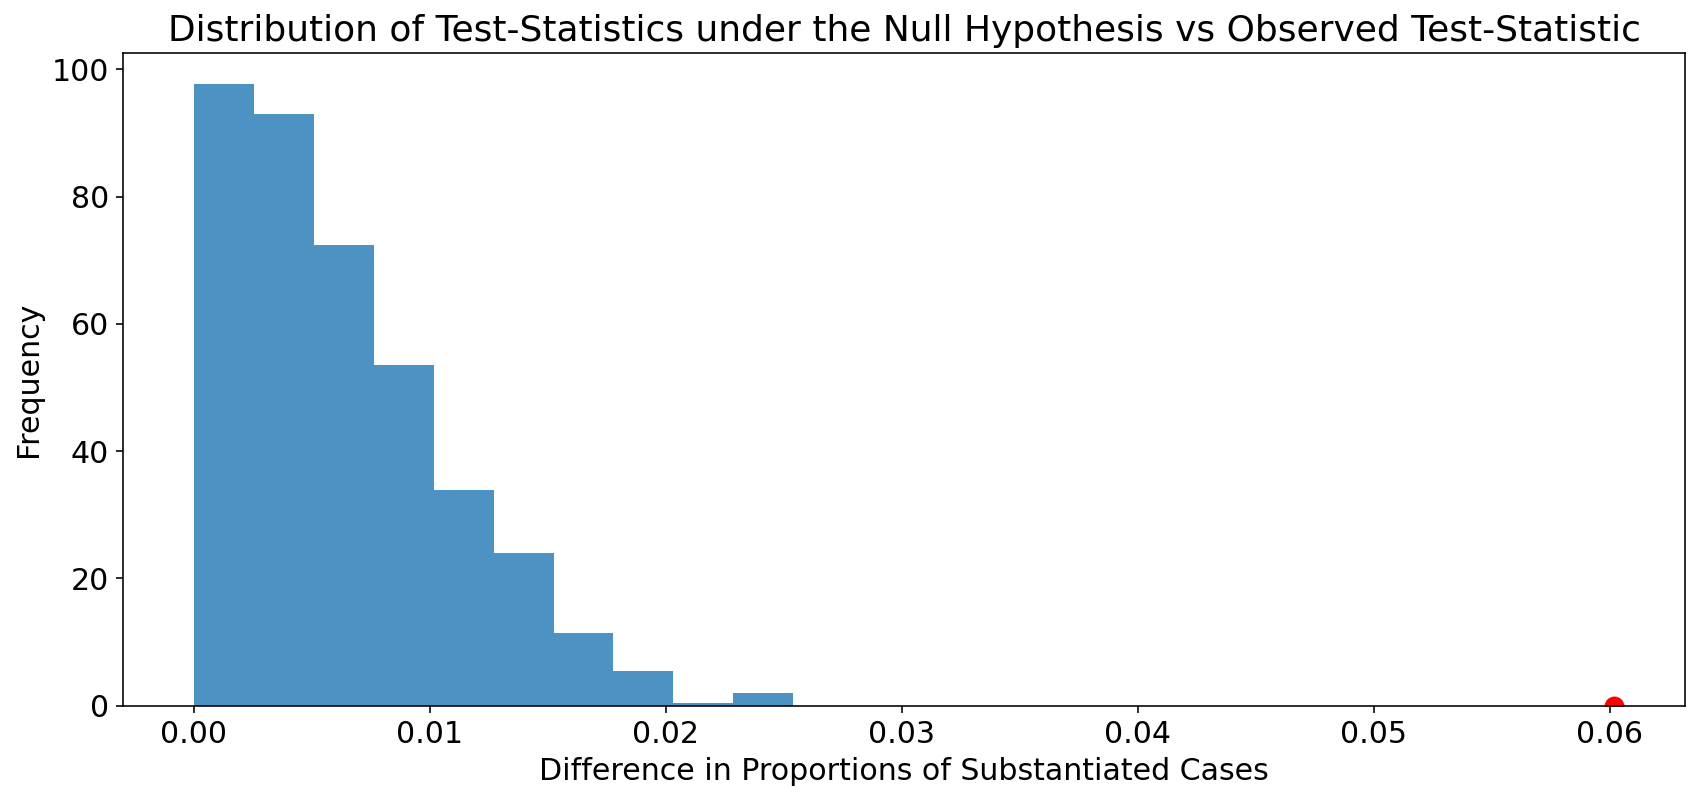

In [449]:
pd.Series(test_stats).plot(kind='hist', density=True, alpha=0.8)
plt.scatter(obs, 0, color='red', s=80);
plt.title('Distribution of Test-Statistics under the Null Hypothesis vs Observed Test-Statistic')
plt.xlabel('Difference in Proportions of Substantiated Cases')
plt.show()

#### Hypothesis Test Conclusions

We can see that our observation is quite extreme under our null hypothesis. This means that we can reject the possibility that the number of substantiated cases for female or male complainants come from the same distribution.

It is important to note that this **does not** indicate that the gender of the complainant influences the outcome of an NYPD complaint case. Rather, it indicates that this *could* be true or that the gender of the complainant is correlated with some other variable (or variables) that do, in fact, influence the outcome of a case.